## UnSu Unet Object Localization

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import he_uniform
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import numpy as np
import matplotlib.pyplot as plt

2024-10-18 01:22:08.489834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 01:22:08.504082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 01:22:08.508755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 01:22:08.520934: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 01:22:09.253075: W tensorflow/compiler/tf2

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


I0000 00:00:1729239730.930730  260436 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729239730.959832  260436 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729239730.959899  260436 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.


In [19]:
# Import custom functions to extract our Image arrays and Pixel Mask arrays from our created fits files dataset
from dataGathering import extractImageArray, extractPixelMaskArray, extract_star_catalog, getStarData, getImagePlot, getPixelMaskPlot, displayImagePlot, displayPixelMaskPlot

# Import astropy to read fits files, and os to interact with the file system
from astropy.io import fits
import os

In [4]:
getStarData('II/246', 100, 'data')

SkyView
Vizier
Save
Save Catalog
Number of stars in catalog query:  517
Number of cataloged stars in image:  347
Drawing
SkyView
Vizier
Save
Save Catalog
Number of stars in catalog query:  577
Number of cataloged stars in image:  361
Drawing
SkyView
Vizier
Save
Save Catalog
Number of stars in catalog query:  1497
Number of cataloged stars in image:  991
Drawing
SkyView
Vizier
Save
Save Catalog
Number of stars in catalog query:  503
Number of cataloged stars in image:  328
Drawing
SkyView
Vizier
Save
Save Catalog
Number of stars in catalog query:  1341
Number of cataloged stars in image:  867
Drawing
SkyView
Vizier
Save
Save Catalog
Number of stars in catalog query:  4596
Number of cataloged stars in image:  2985
Drawing
SkyView
Vizier
Save
Save Catalog
Number of stars in catalog query:  648
Number of cataloged stars in image:  418
Drawing
SkyView
Vizier
Save
Save Catalog
Number of stars in catalog query:  549
Number of cataloged stars in image:  357
Drawing
SkyView
Vizier
Save
Save Cat

In [5]:
# Create images and masks arrays lists
images = []
masks = []

# Create df to store the star data inside each fits file
star_data = []

# Create a list of all the fits files in the dataset folder
fits_files = os.listdir('data/')

# For all the fits files in the dataset folder specified in file_path, extract the image and mask arrays to the respective lists
file_path = 'data/'
for file in os.listdir(file_path):
    if file.endswith('.fits'):
        images.append(extractImageArray(file_path + file))
        masks.append(extractPixelMaskArray(file_path + file))
        star_data.append(extract_star_catalog(file_path + file))

        print(file + ' added to dataset')

data69.fits added to dataset
data7.fits added to dataset
data23.fits added to dataset
data32.fits added to dataset
data20.fits added to dataset
data34.fits added to dataset
data64.fits added to dataset
data30.fits added to dataset
data16.fits added to dataset
data60.fits added to dataset
data70.fits added to dataset
data15.fits added to dataset
data4.fits added to dataset
data78.fits added to dataset
data71.fits added to dataset
data68.fits added to dataset
data5.fits added to dataset
data19.fits added to dataset
data21.fits added to dataset
data85.fits added to dataset
data57.fits added to dataset
data55.fits added to dataset
data92.fits added to dataset
data50.fits added to dataset
data63.fits added to dataset
data49.fits added to dataset
data80.fits added to dataset
data58.fits added to dataset
data12.fits added to dataset
data11.fits added to dataset
data41.fits added to dataset
data14.fits added to dataset
data46.fits added to dataset
data53.fits added to dataset
data24.fits added

In [6]:
masks[0].shape

(512, 512)

In [7]:
# Encoder path
    #32 kernels
    #3x3 kernel size
    #padding = same considers edges in the input
# Example function to create a U-Net model
def unet_model(input_shape, filters, kernel_size, activation, padding, initializer):
    inputs = layers.Input(input_shape)

    # Encoder path
    c1 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(inputs)
    c1 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p1)
    c2 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p2)
    c3 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p3)
    c4 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(filters[4], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p4)
    c5 = layers.Conv2D(filters[4], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c5)

    # Decoder path
    u6 = layers.Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), padding=padding)(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u6)
    c6 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c6)

    u7 = layers.Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding=padding)(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u7)
    c7 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c7)

    u8 = layers.Conv2DTranspose(filters[1], (2, 2), strides=(2, 2), padding=padding)(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u8)
    c8 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c8)

    u9 = layers.Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), padding=padding)(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u9)
    c9 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [8]:
# Prepare the model for training
#############################################

# Define hyperparameters
hyperparameters = {
    'input_shape': (512, 512, 3),
    'filters': [32, 64, 128, 256, 512],
    'kernel_size': (3, 3),
    'activation': 'relu',
    'padding': 'same',
    'initializer': he_uniform(),
    'optimizer': 'adam',
    'loss': 'binary_crossentropy',
    'metrics': ['accuracy'],
    'epochs': 1000,
    'batch_size': 4,
    'validation_split': 0.2,
    'early_stopping_patience': 10
}

# Create and compile the model using hyperparameters
model = unet_model(
    input_shape=hyperparameters['input_shape'],
    filters=hyperparameters['filters'],
    kernel_size=hyperparameters['kernel_size'],
    activation=hyperparameters['activation'],
    padding=hyperparameters['padding'],
    initializer=hyperparameters['initializer']
)
model.compile(
    optimizer=hyperparameters['optimizer'],
    loss=hyperparameters['loss'],
    metrics=hyperparameters['metrics']
)

I0000 00:00:1729240398.000888  260436 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729240398.001039  260436 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729240398.001086  260436 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729240398.203850  260436 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729240398.203998  260436 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-18

In [9]:
# Prepare the data for training
#############################################

# Define the test size
image_parameters = {
    'test_size': 0.2,
    'random_state': 0
}


# Convert lists to numpy arrays
# This ensures that the data is in the correct format for train_test_split and model.fit.
train_images = np.array(images)
train_masks = np.array(masks)



# Ensure the input data has the correct shape
if train_images.ndim == 3: # If images are grayscale and have shape (num_samples, height, width)
    train_images = np.expand_dims(train_images, axis=-1) # Add channel dimension
if train_masks.ndim == 3: # If masks are grayscale and have shape (num_samples, height, width)
    train_masks = np.expand_dims(train_masks, axis=-1) # Add channel dimension


# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=image_parameters['test_size'], random_state=image_parameters['random_state'])

# Duplicate channels for the grayscale images since the model expects 3 channels
train_images = np.repeat(train_images, 3, axis=-1)
val_images = np.repeat(val_images, 3, axis=-1)

# Use ImageDataGenerator to load data in batches
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_images, train_masks, batch_size=hyperparameters['batch_size'])
val_generator = val_datagen.flow(val_images, val_masks, batch_size=hyperparameters['batch_size'])

# Show distribution of training and validation sets
print('Training images: ', train_images.shape)
print('Training masks: ', train_masks.shape)
print('Validation images: ', val_images.shape)
print('Validation masks: ', val_masks.shape)

Training images:  (80, 512, 512, 3)
Training masks:  (80, 512, 512, 1)
Validation images:  (20, 512, 512, 3)
Validation masks:  (20, 512, 512, 1)


In [10]:
# Train the model
#############################################

# Implement Early stopping to cut useless epochs
early_stopping = EarlyStopping(
    monitor='val_loss',  # or another metric like 'val_accuracy'
    patience=hyperparameters['early_stopping_patience'],         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restores the model to the best state after stopping
)


# Train the model
history = model.fit(train_images, train_masks, 
                    validation_data=(val_images, val_masks), 
                    epochs=hyperparameters['epochs'], 
                    batch_size=hyperparameters['batch_size'],
                    callbacks=[early_stopping])

2024-10-18 01:33:21.861749: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 251658240 exceeds 10% of free system memory.
2024-10-18 01:33:23.107122: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 251658240 exceeds 10% of free system memory.


Epoch 1/1000


/home/chris/GitHub/AstrID/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(
I0000 00:00:1729240409.505355  266178 service.cc:146] XLA service 0x7f24c4022ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729240409.505411  266178 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-10-18 01:33:29.649725: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-18 01:33:30.163628: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-18 01:33:39.330772: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.11GiB w

 1/20 ━━━━━━━━━━━━━━━━━━━━ 6:41 21s/step - accuracy: 0.4147 - loss: 541.1117

I0000 00:00:1729240424.685520  266178 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 265ms/step - accuracy: 0.8919 - loss: 237.5879 - val_accuracy: 0.9952 - val_loss: 33.8265
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9693 - loss: 78.4437 - val_accuracy: 0.9952 - val_loss: 72.8438
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9814 - loss: 67.7461 - val_accuracy: 0.9952 - val_loss: 106.7771
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9948 - loss: 115.3536 - val_accuracy: 0.9952 - val_loss: 83.5556
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9929 - loss: 83.3469 - val_accuracy: 0.9926 - val_loss: 10.9679
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9891 - loss: 8.6310 - val_accuracy: 0.9899 - val_loss: 2.9213
Epoch 7/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9904 - loss: 2.7601 - val_accuracy: 0.9942 - val_loss: 2.4832
Epoch 8/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9932 - loss: 3.6461 - val_ac

In [11]:
# Show training loss and validation loss
print('Training loss: ', history.history['loss'][-1])
print('Validation loss: ', history.history['val_loss'][-1])

# Show training accuracy and validation accuracy
print('Training accuracy: ', history.history['accuracy'][-1])
print('Validation accuracy: ', history.history['val_accuracy'][-1])

Training loss:  0.18288490176200867
Validation loss:  0.6106051802635193
Training accuracy:  0.9895407557487488
Validation accuracy:  0.9952011108398438


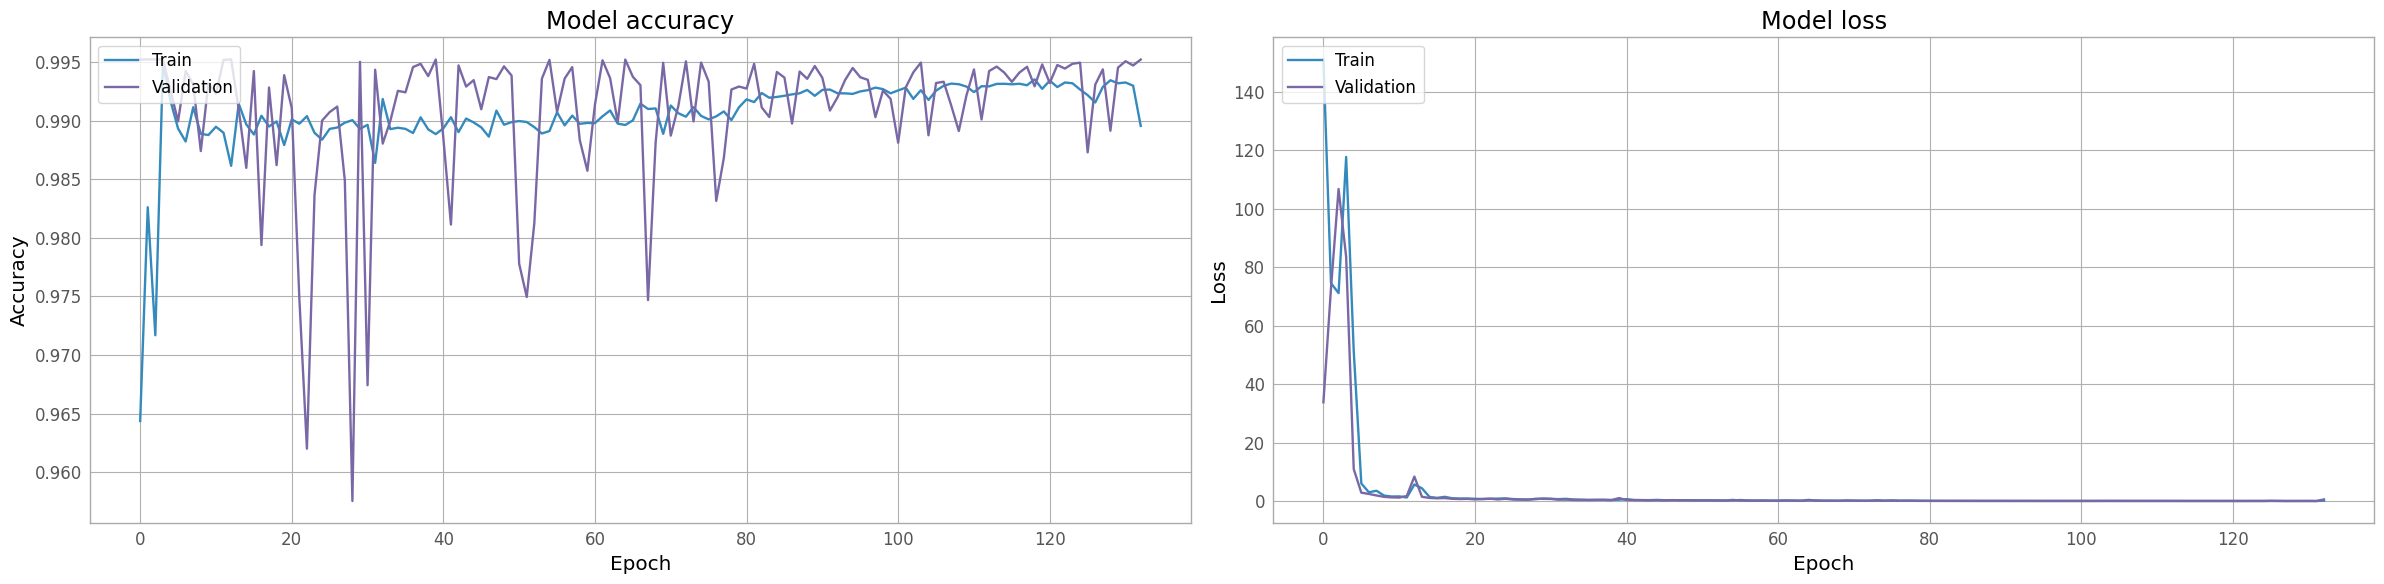

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [13]:
# Save the model
model.save('100unet_model.keras')

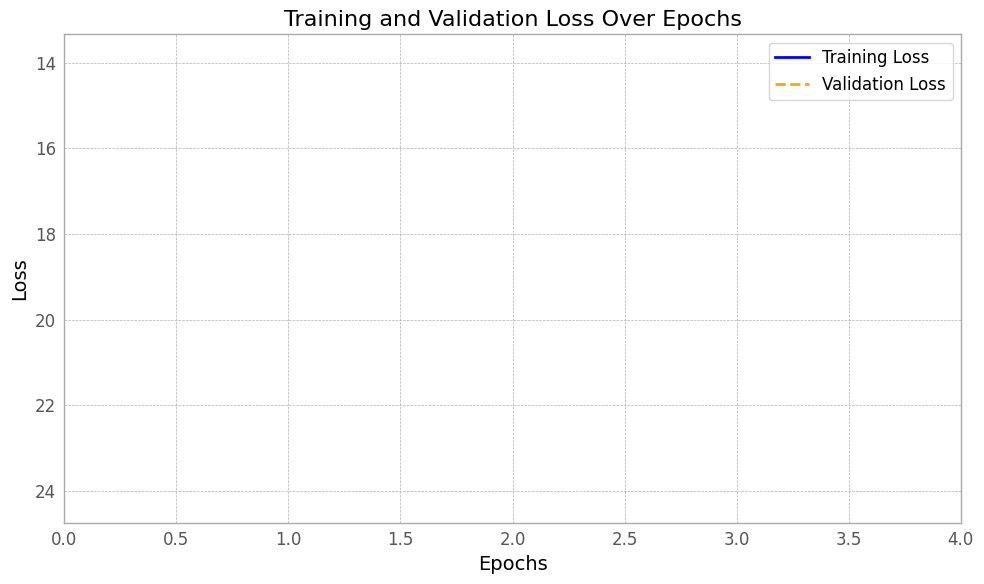

In [40]:



# Set a larger figure size
plt.figure(figsize=(10, 6))

# Plot the training and validation loss
plt.plot(history.history['loss'], color='blue', linestyle='-', linewidth=2, label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', linestyle='--', linewidth=2, label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend to differentiate between training and validation loss
plt.legend(loc='best', fontsize=12)

# Set limits for better visualization
plt.xlim(0, len(history.history['loss']) - 1)  # From epoch 0 to the last epoch
plt.ylim(min(history.history['loss']) * 0.95, max(history.history['val_loss']) * 1.05)

# Show the plot
plt.tight_layout()
plt.show()
